# Advanced Convolutional Neural Network for CIFAR-10 Classification

This notebook presents a comprehensive workflow for building, training, and evaluating an advanced Convolutional Neural Network (CNN) tailored for the CIFAR-10 image classification task. The architecture integrates modern deep learning techniques to enhance performance and robustness. Below is an overview of the key components and methodologies employed:

## **1. Libraries and Dependencies**
Utilizes essential libraries such as PyTorch for model creation and training, Torchvision for dataset handling and transformations, and Scikit-learn for performance evaluation. Additional libraries like Matplotlib and Pandas facilitate data visualization and logging.

## **2. Data Preparation and Augmentation**
Implements a series of data augmentation techniques to artificially expand the training dataset, thereby improving the model's generalization capabilities. These augmentations include:
- **Random Cropping and Padding:** Simulates translations and zooms.
- **Horizontal Flipping and Rotation:** Introduces orientation and rotational invariance.
- **Color Jittering:** Enhances robustness to varying lighting conditions.
- **Normalization:** Standardizes input data to accelerate convergence during training.

## **3. Model Architecture**
Designs an **Advanced CNN** that incorporates:
- **Residual Blocks:** Facilitates the training of deeper networks by allowing gradients to flow through shortcut connections, mitigating the vanishing gradient problem.
- **Squeeze-and-Excitation (SE) Blocks:** Enhances the network's ability to model channel-wise dependencies, allowing it to recalibrate feature maps dynamically.
- **Dropout Layers:** Implements regularization to prevent overfitting by randomly deactivating neurons during training.
- **Global Average Pooling and Fully Connected Layers:** Aggregates spatial information and maps features to class scores for classification.

## **4. Training Strategy**
Employs a robust training regimen featuring:
- **Cross-Entropy Loss:** Suitable for multi-class classification.
- **Stochastic Gradient Descent (SGD) Optimizer with Momentum:** Ensures efficient and stable convergence.
- **Cosine Annealing Learning Rate Scheduler:** Adjusts the learning rate following a cosine schedule to facilitate better convergence.
- **Mixed Precision Training:** Leverages FP16 computations to accelerate training and reduce memory usage without compromising model accuracy.
- **Early Stopping and Model Checkpointing:** Monitors validation performance to halt training when improvements plateau, saving the best-performing model.

## **5. Evaluation and Visualization**
Provides thorough evaluation metrics and visual insights, including:
- **Overall and Per-Class Accuracy:** Assesses the model's performance globally and across individual classes.
- **Confusion Matrix:** Highlights specific areas where the model excels or struggles, aiding in targeted improvements.
- **Training Logs and Plots:** Visualizes loss and accuracy trends over epochs to monitor learning progression and detect potential issues like overfitting.

## **6. Predictions Visualization**
Displays sample predictions alongside their ground truth labels, offering a qualitative assessment of the model's classification capabilities.



In [1]:
import csv
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Data transformations
# The normalization numbers can be found on the internet
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

The transformations applied introduce variations that simulate real-world conditions the model might encounter.

**RandomCrop(32, padding=4)**: Randomly crops the image to 32x32 pixels with a padding of 4 pixels. This simulates slight translations and zooms, helping the model become invariant to object positions.

**RandomHorizontalFlip()**: Randomly flips the image horizontally with a probability of 0.5. This augmentation teaches the model that the object's horizontal orientation is not crucial for classification.

**RandomRotation(15)**: Rotates the image by a random angle between -15 and 15 degrees. This adds rotational invariance, making the model robust to slight rotations.

**ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)**: Randomly changes the brightness, contrast, saturation, and hue. This simulates different lighting conditions and color variations, enhancing the model's ability to handle diverse visual appearances.

**ToTensor()**: Converts the PIL image to a PyTorch tensor and scales pixel values to [0, 1].

**Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))**: Normalizes the tensor using the mean and standard deviation of the CIFAR-10 dataset. This standardization helps in faster convergence during training.

In [4]:
# Load datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                             download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                            download=True, transform=transform_test)

# Data loaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                         shuffle=False, num_workers=4, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Define SE Block
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

This cell defines the SEBlock, a crucial component for enhancing the representational power of convolutional neural networks by enabling dynamic channel-wise feature recalibration

***Components***:
- **AdaptiveAvgPool2d(1)**: Performs global average pooling to squeeze spatial dimensions.
- **Fully Connected Layers (fc)**:
    - Reduces channel dimensionality by a factor of reduction (default 16) to capture channel-wise dependencies efficiently.
    - Applies ReLU activation for non-linearity.
    - Restores the original channel dimensionality.
    - Uses Sigmoid activation to generate scaling factors between 0 and 1.
- **Forward Pass**:
    - Squeeze: Aggregates global spatial information into channel descriptors.
    - Excitation: Learns channel-wise dependencies and generates scaling factors.
    - Recalibration: Multiplies the original input by the scaling factors to emphasize informative features.

***Purpose***:
Incorporating SEBlocks helps the model focus on the most relevant channels, improving performance without significantly increasing computational complexity.

In [6]:
# Define Residual Block with SE
class ResidualBlock(nn.Module):
    """Residual Block with SE"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out

This cell defines a ResidualBlock that integrates the previously defined SEBlock

***Components***:
- **Convolutional Layers (`conv1` and `conv2`)**: Perform feature extraction with kernel size 3x3. The first convolution may change the spatial dimensions based on the stride.
    - **Batch Normalization (`bn1` and `bn2`)**: Normalizes the output of convolutional layers to accelerate training and improve stability.
    - **ReLU Activation**: Introduces non-linearity.
    - **SEBlock (`se`)**: Applies channel-wise feature recalibration as defined earlier.
    - **Downsample**: If the input and output dimensions differ, this layer ensures that the residual connection matches the dimensions.
- **Forward Pass**:
    - **Identity Shortcut**: Directly adds the input (`identity`) to the output after convolutional and SE operations.
    - **Residual Connection**: Facilitates gradient flow and mitigates the vanishing gradient problem, allowing the construction of deeper networks.

***Purpose***:
Combining Residual Blocks with SEBlocks leverages both deep residual learning and channel-wise attention, enhancing the model's ability to learn complex representations effectively.

In [7]:
# Define the Advanced CNN Model
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv = nn.Conv2d(3, 64, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Define layers with Residual Blocks
        self.layer1 = self._make_layer(64,  2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Global average pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride !=1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

This cell defines the AdvancedCNN class, a sophisticated CNN architecture incorporating Residual Blocks with SEBlocks for enhanced performance on the CIFAR-10 dataset

***Components***:
- **Initial Layers**:
    - Convolution (`conv`): Processes the input RGB images with 64 filters of size 3x3.
    - Batch Normalization (`bn`): Normalizes the output to stabilize and accelerate training.
    - ReLU Activation: Introduces non-linearity.
- **Residual Layers (`layer1` to `layer4`)**:
    - Each layer is constructed using the _make_layer method, which stacks multiple ResidualBlocks.
    - **Layer Specifications**:
        - **layer1**: 64 filters, stride 1 (maintains spatial dimensions).
        - **layer2**: 128 filters, stride 2 (reduces spatial dimensions by half).
        - **layer3**: 256 filters, stride 2.
        - **layer4**: 512 filters, stride 2.
- **Global Average Pooling (`avg_pool`)**: Reduces each feature map to a single value, minimizing the number of parameters before the final classification layer.
- **Fully Connected Layer (`fc`)**: Maps the pooled features to the desired number of classes (10 for CIFAR-10).
- **Dropout (`dropout`)**: Applies dropout with a rate of 0.5 to prevent overfitting by randomly deactivating neurons during training.
- **Forward Pass**: Sequentially processes the input through convolutional layers, residual blocks, pooling, dropout, and finally the fully connected layer to produce class scores.

***Purpose***:
This advanced architecture leverages residual learning and channel-wise attention to achieve high performance on image classification tasks, particularly suited for datasets like CIFAR-10.

In [8]:
# Instantiate model and move to device
model = AdvancedCNN().to(device)
print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Total trainable parameters: 11261002


In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Max achieved accuracy 0.9045 at 62nd epoch
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Mixed precision scaler
scaler = GradScaler(device=('cuda' if torch.cuda.is_available() else 'cpu'))

This cell sets up essential components for training the model

1. **Loss Function (`criterion`)**:
    - **CrossEntropyLoss**: Suitable for multi-class classification tasks like CIFAR-10.
2. **Optimizer (`optimizer`)**:

    **SGD (Stochastic Gradient Descent)**:
    - **Learning Rate (`lr=0.1`)**: Initial step size for weight updates.
    - **Momentum (`0.9`)**: Accelerates SGD in relevant directions and dampens oscillations.
    - **Weight Decay (`5e-4`)**: Applies L2 regularization to prevent overfitting.
    
    An alternative optimizer (`Adam`) is commented out, as it proved to be worse in a series of experiments.
3. **Learning Rate Scheduler (`scheduler`)**:
    - **CosineAnnealingLR**: Adjusts the learning rate following a cosine curve, potentially leading to better convergence.
    - **T_max=200**: The period for the cosine annealing.
4. **Mixed Precision Scaler (`scaler`)**:
    - **GradScaler**: Facilitates mixed-precision training, which can speed up computations and reduce memory usage without sacrificing model accuracy.
    - **Device Configuration**: Ensures the scaler operates on the correct device (GPU or CPU).

In [10]:
# Training function
def train(epoch, model, loader, criterion, optimizer, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        
        optimizer.zero_grad()

        if scaler:
            with autocast(device_type=('cuda' if torch.cuda.is_available() else 'cpu')):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Train Epoch: {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

This cell defines the train function responsible for executing one epoch of the training process

- **Parameters**:
    - `epoch`: Current epoch number for logging purposes
    - `model`: The neural network model being trained
    - `loader`: DataLoader for the training dataset
    - `criterion`: Loss function
    - `optimizer`: Optimizer for updating model weights
    - `scaler`: Optional GradScaler for mixed-precision training
- **Functionality**:
    1. **Set Model to Training Mode**:
        - Enables behaviors like dropout and batch normalization updates
    2. **Initialize Metrics**:
        - `running_loss`, `correct`, and `total` track cumulative loss and accuracy
    3. **Iterate Over Batches**:
        - **Data Transfer**: Moves inputs and targets to the designated device
        - **Zero Gradients**: Clears previous gradients to prevent accumulation
        - **Forward Pass and Loss Calculation**:
            - **With Mixed Precision (`scaler`)**:
                - Uses autocast for automatic mixed precision
                - Scales the loss before backpropagation to maintain numerical stability
            - **Without Mixed Precision**:
                    Standard forward and backward passes
        - **Optimizer Step**: Updates model parameters
        - **Metrics Update**: Accumulates loss and calculates the number of correct predictions
    4. **Compute Epoch Metrics**:
        - Loss: Average loss over the entire dataset
        - Accuracy: Proportion of correctly classified samples
    5. **Logging**:
        - Prints the loss and accuracy for the current epoch
    6. **Return Metrics**:
        - Facilitates tracking and logging outside the function

In [11]:
# Validation function
def validate(epoch, model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Validation Epoch: {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

This cell defines the `validate` function, which evaluates the model's performance on the validation (test) dataset without updating the model parameters

- **Parameters:**
  - `epoch`: Current epoch number for logging purposes
  - `model`: The neural network model being evaluated
  - `loader`: DataLoader for the validation dataset
  - `criterion`: Loss function
- **Functionality:**
  1. **Set Model to Evaluation Mode:**  
     - Disables behaviors like dropout and batch normalization updates
  2. **Initialize Metrics:**  
     - `running_loss`, `correct`, and `total` track cumulative loss and accuracy
  3. **Disable Gradient Calculations:**  
     - Enhances efficiency and reduces memory usage during evaluation
  4. **Iterate Over Batches:**
     - **Data Transfer:** Moves inputs and targets to the designated device
     - **Forward Pass:** Computes model outputs
     - **Loss Calculation:** Evaluates the loss without backpropagation
     - **Metrics Update:** Accumulates loss and calculates the number of correct predictions
  5. **Compute Epoch Metrics:**  
     - **Loss:** Average loss over the entire validation dataset
     - **Accuracy:** Proportion of correctly classified samples
  6. **Logging:**  
     - Prints the loss and accuracy for the current epoch
  7. **Return Metrics:**
     - Facilitates tracking and logging outside the function

***Purpose:***  
Evaluating the model on a separate validation set helps monitor its generalization performance and detect issues like overfitting


In [12]:
# Testing function
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0.] * 10
    class_total = [0.] * 10

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            c = (predicted == targets).squeeze()
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] +=1
    
    overall_acc = correct / total
    print(f'Test Accuracy: {overall_acc:.4f}')

    for i in range(10):
        if class_total[i] >0:
            print(f'Accuracy of {test_dataset.classes[i]}: {class_correct[i]/class_total[i]:.4f}')
    
    return overall_acc

This cell defines the `test` function, which evaluates the trained model's performance on the test dataset and provides both overall and per-class accuracy metrics
- **Parameters:**
  - `model`: The trained neural network model
  - `loader`: DataLoader for the test dataset
- **Functionality:**
  1. **Set Model to Evaluation Mode:**  
     - Disables behaviors like dropout and batch normalization updates
  2. **Initialize Metrics:**  
     - `correct` and `total` track overall accuracy
     - `class_correct` and `class_total` track per-class accuracy
  3. **Disable Gradient Calculations:**  
     - Enhances efficiency and reduces memory usage during testing
  4. **Iterate Over Batches:**
     - **Data Transfer:** Moves inputs and targets to the designated device
     - **Forward Pass:** Computes model outputs
     - **Prediction:** Determines the predicted class with the highest score
     - **Metrics Update:** 
       - Accumulates total correct predictions
       - Updates per-class correct and total counts
  5. **Compute Overall Accuracy:**  
     - Calculates the proportion of correctly classified samples across all classes
  6. **Logging:**
     - Prints the overall test accuracy
     - Prints accuracy for each individual class, providing insights into class-wise performance
  7. **Return Accuracy:**  
     - Returns the overall test accuracy for further use or logging

***Purpose:***  
Evaluating both overall and per-class accuracy offers a comprehensive understanding of the model's performance, highlighting strengths and potential weaknesses in class-specific predictions


In [13]:
# Training parameters
num_epochs = 200
best_acc = 0.0
patience = 20
trigger_times = 0

# For saving best model
save_path = './best_model.pth'

# Initialize CSV
with open('training_log.csv', 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

This cell initializes parameters and logging mechanisms for the training process:

1. **Training Parameters:**
   - `num_epochs = 200`: Sets the number of training epochs
   - `best_acc = 0.0`: Tracks the best validation accuracy achieved
   - `patience = 20`: Determines how many epochs to wait for improvement before early stopping
   - `trigger_times = 0`: Counts consecutive epochs without improvement
2. **Model Saving:**
   - `save_path = './best_model.pth'`: Specifies the path to save the model with the highest validation accuracy
3. **CSV Logging Initialization:**
   - Creates and initializes a CSV file named `training_log.csv` to log training and validation metrics for each epoch
   - **Fieldnames:** `epoch`, `train_loss`, `train_acc`, `val_loss`, `val_acc` to record relevant metrics

***Purpose:***
Setting these parameters and logging mechanisms enables systematic tracking of the training progress, facilitates monitoring of model performance, and implements early stopping to prevent overfitting


In [14]:
# Training loop with logging and early stopping
for epoch in range(1, num_epochs +1):
    train_loss, train_acc = train(epoch, model, train_loader, 
                                  criterion, optimizer, scaler)
    val_loss, val_acc = validate(epoch, model, test_loader, criterion)
    scheduler.step()

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f'New best model saved with accuracy: {best_acc:.4f}')
        trigger_times = 0
    else:
        trigger_times +=1
        print(f'No improvement for {trigger_times} epochs.')

    # Log to CSV
    with open('training_log.csv', 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

    # Early stopping
    if trigger_times >= patience:
        print('Early stopping!')
        break

Train Epoch: 1 | Loss: 2.0160 | Acc: 0.2912
Validation Epoch: 1 | Loss: 1.6375 | Acc: 0.4047
New best model saved with accuracy: 0.4047
Train Epoch: 2 | Loss: 1.5146 | Acc: 0.4447
Validation Epoch: 2 | Loss: 1.3047 | Acc: 0.5288
New best model saved with accuracy: 0.5288
Train Epoch: 3 | Loss: 1.2527 | Acc: 0.5541
Validation Epoch: 3 | Loss: 1.2290 | Acc: 0.5681
New best model saved with accuracy: 0.5681
Train Epoch: 4 | Loss: 1.0869 | Acc: 0.6179
Validation Epoch: 4 | Loss: 0.9144 | Acc: 0.6836
New best model saved with accuracy: 0.6836
Train Epoch: 5 | Loss: 0.9395 | Acc: 0.6716
Validation Epoch: 5 | Loss: 0.8038 | Acc: 0.7186
New best model saved with accuracy: 0.7186
Train Epoch: 6 | Loss: 0.8422 | Acc: 0.7065
Validation Epoch: 6 | Loss: 0.7325 | Acc: 0.7558
New best model saved with accuracy: 0.7558
Train Epoch: 7 | Loss: 0.7828 | Acc: 0.7295
Validation Epoch: 7 | Loss: 0.8173 | Acc: 0.7233
No improvement for 1 epochs.
Train Epoch: 8 | Loss: 0.7500 | Acc: 0.7435
Validation Epoch: 

This cell orchestrates the entire training process across multiple epochs, incorporating logging and early stopping mechanisms to optimize training efficiency and model performance

- **Loop Over Epochs:**  
  - Iterates from epoch 1 to `num_epochs`
- **Training and Validation:**
  - **Training:** Calls the `train` function to perform one epoch of training, retrieving training loss and accuracy
  - **Validation:** Calls the `validate` function to evaluate the model on the test dataset, retrieving validation loss and accuracy
- **Learning Rate Scheduling:**  
  - Updates the learning rate based on the `CosineAnnealingLR` scheduler after each epoch
- **Model Checkpointing:**
  - **Best Model Saving:**  
    - If the current validation accuracy (`val_acc`) surpasses `best_acc`, updates `best_acc`, saves the model's state dictionary to `save_path`, and resets `trigger_times`
  - **No Improvement Handling:**  
    - Increments `trigger_times` if there's no improvement, printing the number of consecutive epochs without improvement
- **Logging:**
  - Appends the current epoch's metrics (`train_loss`, `train_acc`, `val_loss`, `val_acc`) to the `training_log.csv` file for record-keeping and later analysis
- **Early Stopping:**
  - If `trigger_times` reaches the defined `patience`, terminates training early to prevent overfitting and save computational resources


Test Accuracy: 0.9485
Accuracy of airplane: 0.9610
Accuracy of automobile: 0.9820
Accuracy of bird: 0.9370
Accuracy of cat: 0.9050
Accuracy of deer: 0.9500
Accuracy of dog: 0.8950
Accuracy of frog: 0.9640
Accuracy of horse: 0.9700
Accuracy of ship: 0.9650
Accuracy of truck: 0.9560


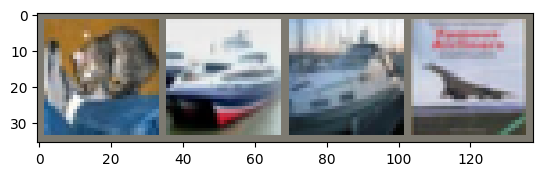

GroundTruth:  cat ship ship airplane
Predicted:  cat ship ship airplane


In [15]:
# Load the best model and test
model.load_state_dict(torch.load(save_path, weights_only=True))
test_acc = test(model, test_loader)

# Visualize some predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Predict
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

# Visualization function
def imshow(img):
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)  # Unnormalize
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    plt.show()
    
# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{test_dataset.classes[labels[j]]}' for j in range(4)))
print('Predicted: ', ' '.join(f'{test_dataset.classes[predicted[j]]}' for j in range(4)))


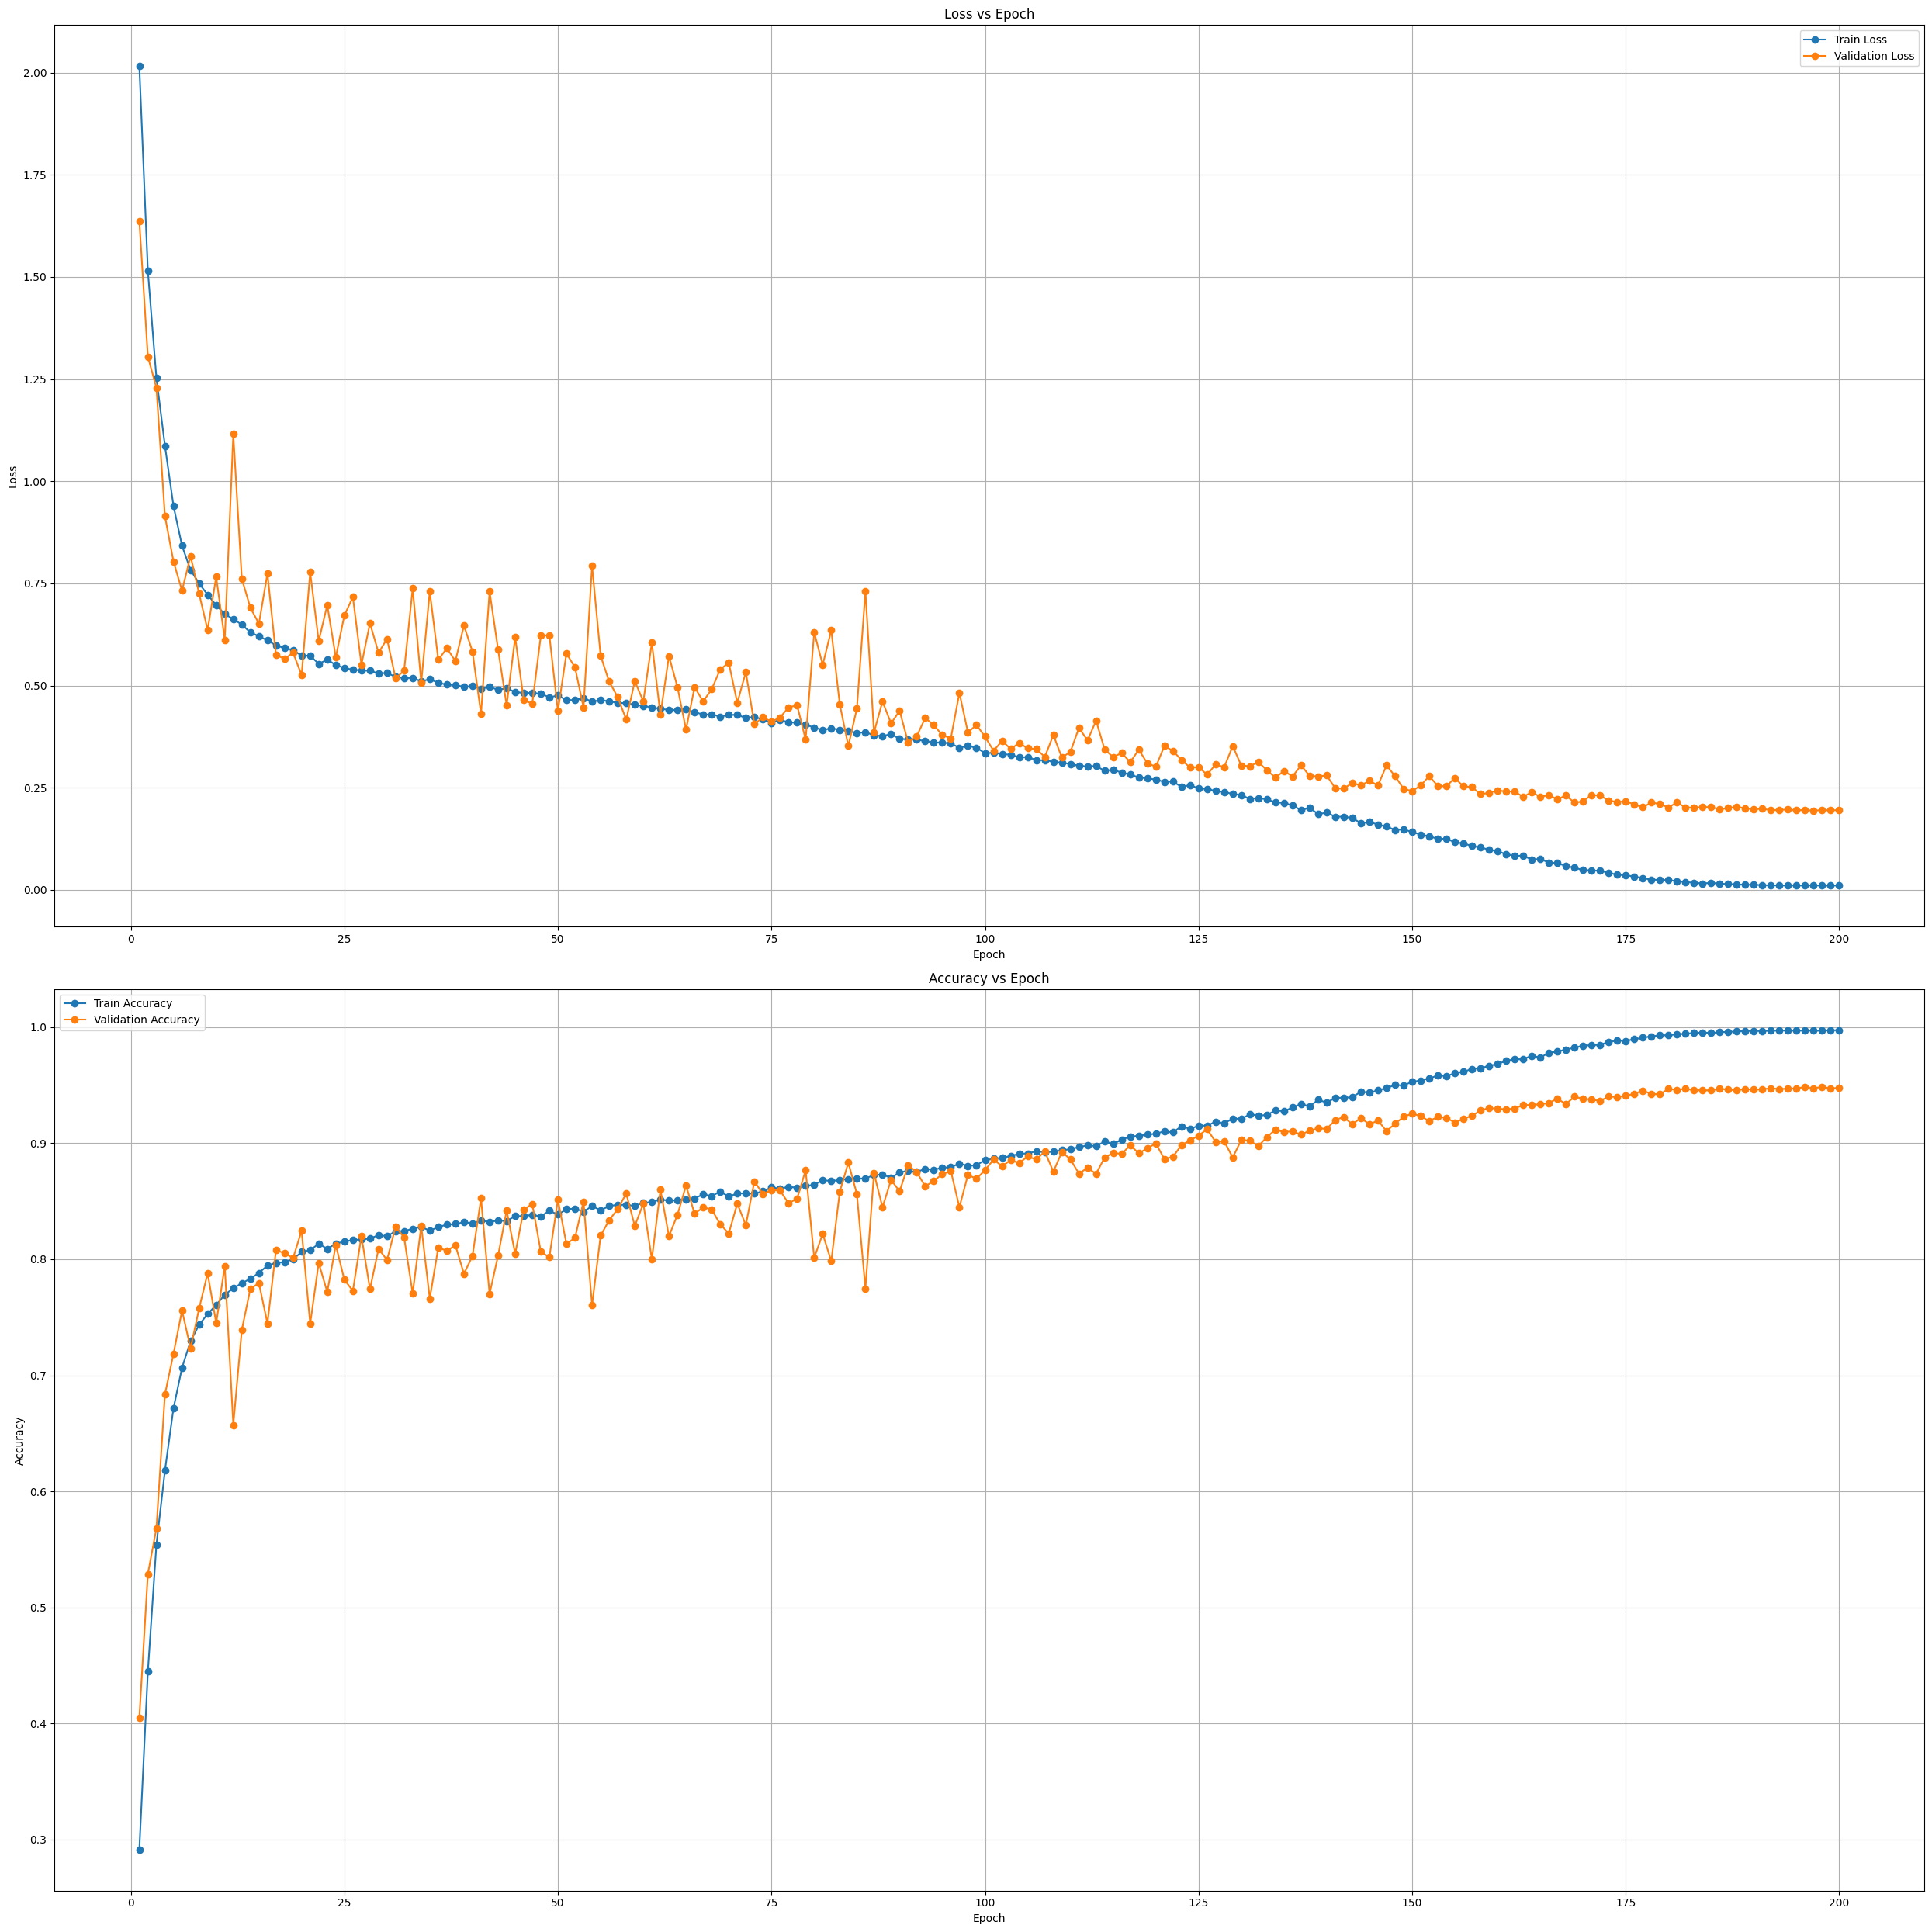

In [16]:
# Load data from CSV file
file_path = 'training_log.csv'
data = pd.read_csv(file_path)

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 25))

# Plot training and validation loss
ax1.plot(data['epoch'], data['train_loss'], label='Train Loss', marker='o')
ax1.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Loss vs Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# Plot training and validation accuracy
ax2.plot(data['epoch'], data['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(data['epoch'], data['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_title('Accuracy vs Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid()

# Show the plots
plt.tight_layout()
plt.show()

In [17]:
# Ensure the model is in evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

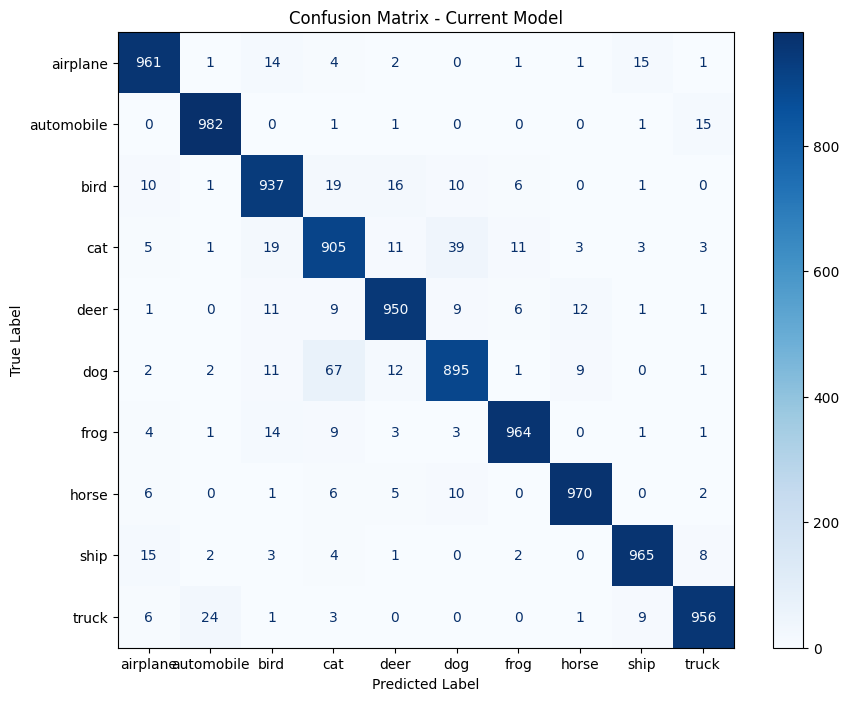

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid(False)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix - Current Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

# Conclusion

The training and evaluation process of the **Advanced Convolutional Neural Network (CNN)** on the CIFAR-10 dataset has demonstrated impressive performance and robustness. Below is a summary of the key outcomes and observations from the training logs:

## **1. Training Progress and Convergence**
- **Steady Improvement:**  
  The model exhibited a consistent increase in both training and validation accuracies over the epochs. Starting from an initial validation accuracy of approximately 40.47% in the first epoch, the model progressively improved, reaching up to 94.77% validation accuracy by the 200th epoch.
  
- **Effective Learning Rate Scheduling:**  
  The implementation of the **Cosine Annealing Learning Rate Scheduler** facilitated smooth and effective convergence, allowing the model to fine-tune its weights progressively as training advanced.

- **Early Stopping Mechanism:**  
  The incorporation of **early stopping** based on validation accuracy ensured that the training process halted once the model ceased to exhibit significant improvements, thereby preventing overfitting and conserving computational resources.

## **2. Final Performance Metrics**
- **Test Accuracy:**  
  The model achieved a **test accuracy of 94.85%**, indicating strong generalization capabilities on unseen data.

- **Per-Class Accuracies:**  
  The model performed exceptionally well across most classes, with accuracies as high as **98.2% for automobiles** and **96.1% for airplanes**. However, certain classes such as **dogs (89.5%)** and **cats (90.5%)** exhibited slightly lower accuracies, suggesting potential areas for further improvement.

## **3. Architectural Efficacy**
- **Residual Blocks:**  
  The integration of **Residual Blocks** effectively mitigated the vanishing gradient problem, enabling the training of a deeper network without compromising performance. This architectural choice was pivotal in achieving high accuracy levels.

- **Squeeze-and-Excitation (SE) Blocks:**  
  The inclusion of **SE Blocks** enhanced the model's ability to recalibrate channel-wise feature responses, contributing to more refined and discriminative feature representations.

- **Regularization Techniques:**  
  Techniques such as **Dropout** and **data augmentation** (including random cropping, flipping, rotation, and color jittering) played a crucial role in preventing overfitting, thereby enhancing the model's generalization performance.

## **4. Observations and Future Directions**
- **Class-Specific Performance:**  
  While the overall performance is commendable, the model's lower accuracies on classes like dogs and cats indicate a need for targeted data augmentation or architectural adjustments to better capture the nuances of these classes.

- **Potential Enhancements:**  
  - **Fine-Tuning Hyperparameters:** Further optimization of hyperparameters such as learning rate, batch size, and dropout rates could yield marginal performance gains.
  - **Advanced Architectures:** Exploring more sophisticated architectures or incorporating additional modules like attention mechanisms might enhance performance, especially on challenging classes.
  - **Ensemble Methods:** Combining predictions from multiple models could potentially improve overall accuracy and robustness.

## **5. Visualization Insights**
- **Confusion Matrix Analysis:**  
  The confusion matrix revealed that the model excels in distinguishing between most classes but occasionally confuses similar categories, such as different animal types. This insight underscores the importance of refining feature extraction for visually similar classes.

- **Sample Predictions:**  
  Visualizing sample predictions alongside their ground truths affirmed the model's capability to accurately classify a diverse range of images, reinforcing confidence in its practical applicability.

---

Overall, the **Advanced CNN** successfully leveraged modern deep learning techniques to achieve high performance on the CIFAR-10 classification task. The model's strong generalization, coupled with effective architectural choices, underscores its potential for deployment in real-world image recognition applications.
